The purpose of this notebook is to develop the logic for plotting NWM predictions alongside reach-level IQR statistics.

In [1]:
import io
import requests
import xarray
import pandas
import creds
import calendar
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta

import utilities


In [2]:
import importlib
importlib.reload(utilities)

<module 'utilities' from '/Users/castro/Documents/work/com_res/fim/generate-fim-inputs/utilities.py'>

In [3]:
%matplotlib widget

In [15]:
reach_id = 10102374   
start_time = '2015-06-01'
end_time =  '2026-03-01'

# reach_id = 8585160
# start_time = '2022-11-01'
# end_time =  '2023-02-28'

output_format = 'csv'

In [16]:
API_KEY = creds.key
API_URL = creds.url

header = {
    'x-api-key': API_KEY
}

ENDPOINT = f'{API_URL}/analysis-assim'

params = {
    'comids': reach_id,
    'start_time': start_time,
    'end_time': end_time,
    'output_format': output_format,
}

r = requests.get(ENDPOINT,
                 params=params,
                 headers=header)

if r.status_code == 200:
    print('Request was Sucessful ;)')
else:
    print(f'The request was not successful: {r.status_code}')

df = pandas.read_csv(io.StringIO(r.text), sep=',')
df.set_index('time', inplace=True)
df.index = pandas.to_datetime(df.index)
df

Request was Sucessful ;)


,feature_id,streamflow,velocity
time,,,
2018-09-16 22:00:00,10102374,0.66,0.05
2018-09-16 23:00:00,10102374,0.66,0.05
2018-09-17 00:00:00,10102374,0.66,0.05
2018-09-17 01:00:00,10102374,0.66,0.05
2018-09-17 02:00:00,10102374,0.67,0.05
...,...,...,...
2025-10-28 17:00:00,10102374,0.36,0.31
2025-10-28 18:00:00,10102374,0.36,0.31
2025-10-28 19:00:00,10102374,0.36,0.31


In [13]:
import sys
sys.getsizeof(quantiles) / 1024 /1024

77.90681457519531

TODO:

 - TC: Create BigQuery table with these data.
 - 

In [17]:
# read computed statistics.
quantiles = pandas.read_parquet('all_quantiles_good.parquet')

# get data for the chosen reach
stats = quantiles.loc[quantiles.feature_id == reach_id]

# align statistics with NWM data
stats_df = utilities.align_quantiles_with_timeseries(stats, df.index)

In [18]:
stats

,feature_id,doy,q0,q5,q10,q25,q75,q90,q100
411750,10102374,1.0,0.88,2.900,1.300,1.9400,5.0700,7.620,13.040000
411751,10102374,2.0,0.84,2.680,1.250,1.7800,5.0050,6.875,11.830000
411752,10102374,3.0,0.85,2.580,1.180,1.8100,4.5600,6.370,10.730000
411753,10102374,4.0,0.89,2.690,1.200,1.7800,4.3000,6.030,14.750000
411754,10102374,5.0,0.91,2.755,1.315,1.7700,4.3525,6.740,30.189999
...,...,...,...,...,...,...,...,...,...
412111,10102374,362.0,0.88,3.400,1.510,2.1500,5.9250,8.585,30.229999
412112,10102374,363.0,0.85,3.220,1.520,2.0900,6.0400,8.770,29.549999
412113,10102374,364.0,0.88,3.055,1.430,2.0475,5.7550,8.240,16.580000
412114,10102374,365.0,0.92,2.885,1.410,2.0400,5.4900,9.360,22.350000


In [19]:
stats_df

,feature_id,doy,q0,q5,q10,q25,q75,q90,q100
datetime,,,,,,,,,
2018-09-16,10102374,259.0,0.08,1.660,0.160,0.5100,3.6300,7.550,18.310000
2018-09-17,10102374,260.0,0.09,1.620,0.160,0.6725,3.5125,6.770,65.429999
2018-09-18,10102374,261.0,0.09,1.515,0.160,0.7025,3.4350,6.370,54.259999
2018-09-19,10102374,262.0,0.09,1.600,0.160,0.7675,3.6300,5.760,32.779999
2018-09-20,10102374,263.0,0.09,1.790,0.150,0.7400,4.1600,10.750,49.679999
...,...,...,...,...,...,...,...,...,...
2025-10-24,10102374,297.0,0.12,4.800,1.890,2.9875,7.8450,16.180,63.449999
2025-10-25,10102374,298.0,0.15,4.725,1.910,3.0275,7.6025,14.315,86.479998
2025-10-26,10102374,299.0,0.18,4.615,1.905,3.0000,8.2150,12.145,40.569999


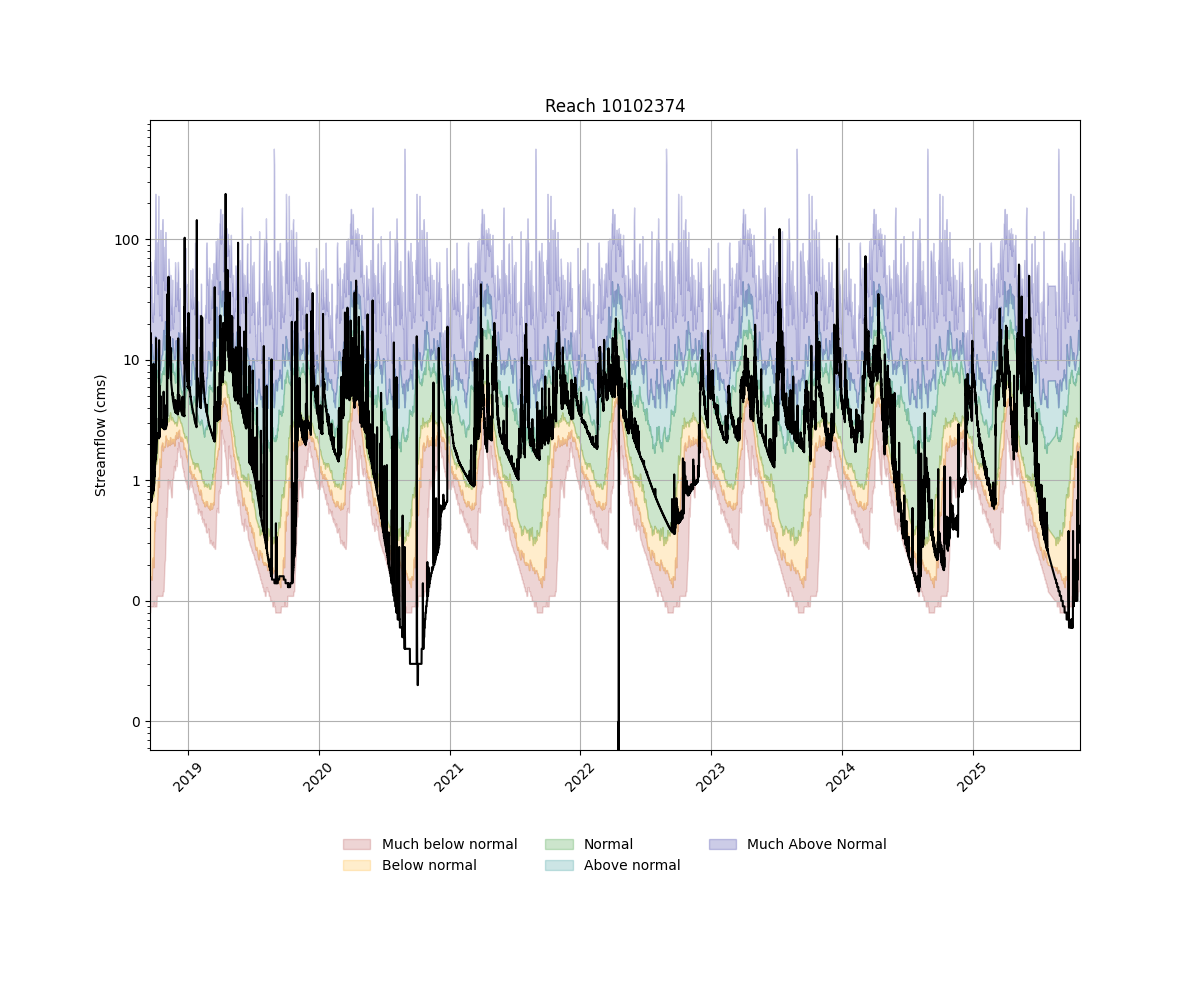

In [20]:
fig, ax = utilities.create_quantile_plot(stats_df, xfield='datetime')

ax.plot(df.index,
        df.streamflow,
        color='black',
        label='Streamflow');
plt.show()

In [10]:
df.index = pandas.to_datetime(df.index)

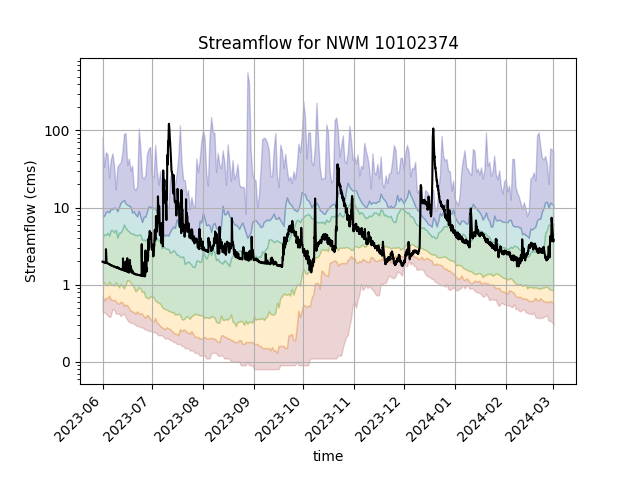

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 


# daily_max.streamflow.plot(ax=ax, color='red')

df.streamflow.plot(ax=ax,
                   grid=True,
                   rot=45,
                   color='black',
                   title=f'Streamflow for NWM {reach_id}',
                   ylabel='Streamflow (cms)');
ax.fill_between(
        df_clean.index,          # x values
        df_clean.q0,            # lower bound
        df_clean.q10,            # upper bound
        color='brown',             # fill color
        alpha=0.2,                # transparency
        label='Much Below Normal'       # legend label
    );


ax.fill_between(
        df_clean.index,          # x values
        df_clean.q10,            # lower bound
        df_clean.q25,            # upper bound
        color='orange',             # fill color
        alpha=0.2,                # transparency
        label='Below Normal'       # legend label
    );

ax.fill_between(
        df_clean.index,          # x values
        df_clean.q25,            # lower bound
        df_clean.q75,            # upper bound
        color='green',             # fill color
        alpha=0.2,                # transparency
        label='Normal'       # legend label
    );

ax.fill_between(
        df_clean.index,          # x values
        df_clean.q75,            # lower bound
        df_clean.q90,            # upper bound
        color='teal',             # fill color
        alpha=0.2,                # transparency
        label='Above Normal'       # legend label
    );
ax.fill_between(
        df_clean.index,          # x values
        df_clean.q90,            # lower bound
        df_clean.q100,            # upper bound
        color='darkblue',             # fill color
        alpha=0.2,                # transparency
        label='Much Above Normal'       # legend label
    );

#plt.legend()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))

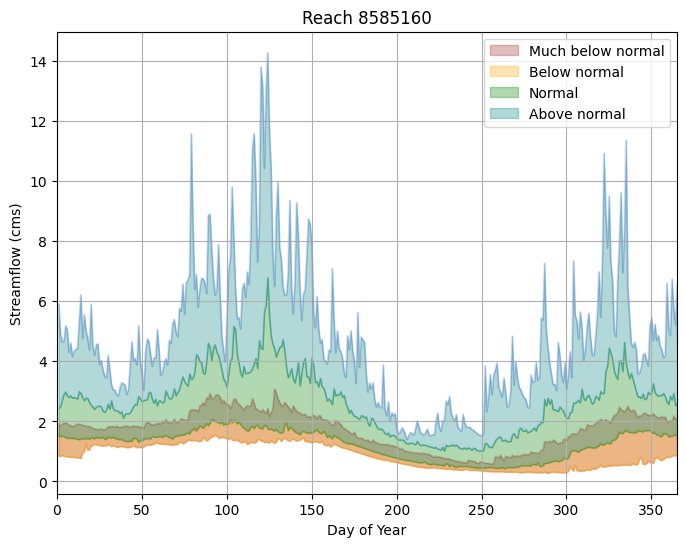

In [228]:
import utilities
dat = quantiles.loc[quantiles.feature_id == reach_id]
utilities.create_quantile_plot(dat)

In [362]:
import S3hsclient as hsclient
hs = hsclient.S3HydroShare()

res = hs.resource('446999d3f27149cea4ee9863d2de7ad2')
all_dat = pandas.read_parquet('tonycastronova/446999d3f27149cea4ee9863d2de7ad2/data/contents/RoaringRiver.parquet',
                              engine='pyarrow',
                              filesystem=res._hs_session.s3)

#all_dat = pandas.read_parquet(f'RoaringRiver_quantiles.parquet', engine='pyarrow')

Username:  TonyCastronova
Password for TonyCastronova:  ········


In [363]:
#all_dat.set_index('time', inplace=True)
all_dat.reset_index(inplace=True)

In [364]:
def doy_366(dt):
    doy = dt.timetuple().tm_yday
    # Shift days after Feb 28 for non-leap years
    if not dt.is_leap_year and doy >= 60:
        return doy + 1
    return doy

In [365]:
d = all_dat.loc[all_dat.feature_id == reach_id].copy()


In [366]:
d['doy'] = d['time'].apply(doy_366)

In [367]:
d

,index,time,feature_id,streamflow,doy
16,16,1979-02-01 01:00:00,8585160,1.34,32
339,339,1979-02-01 02:00:00,8585160,1.35,32
662,662,1979-02-01 03:00:00,8585160,1.35,32
985,985,1979-02-01 04:00:00,8585160,1.35,32
1308,1308,1979-02-01 05:00:00,8585160,1.35,32
...,...,...,...,...,...
124580793,124580793,2023-01-31 20:00:00,8585160,1.73,31
124581116,124581116,2023-01-31 21:00:00,8585160,1.73,31
124581439,124581439,2023-01-31 22:00:00,8585160,1.73,31
124581762,124581762,2023-01-31 23:00:00,8585160,1.73,31


In [281]:
d.set_index('time', inplace=True)
d = d.loc['2015-01-01':'2025-01-01']

In [291]:
d

,index,time,feature_id,streamflow
16,16,1979-02-01 01:00:00,8585160,1.34
339,339,1979-02-01 02:00:00,8585160,1.35
662,662,1979-02-01 03:00:00,8585160,1.35
985,985,1979-02-01 04:00:00,8585160,1.35
1308,1308,1979-02-01 05:00:00,8585160,1.35
...,...,...,...,...
124580793,124580793,2023-01-31 20:00:00,8585160,1.73
124581116,124581116,2023-01-31 21:00:00,8585160,1.73
124581439,124581439,2023-01-31 22:00:00,8585160,1.73
124581762,124581762,2023-01-31 23:00:00,8585160,1.73


In [283]:
def compute_quantiles(subdf, quantiles=[], quantile_names=None):
    q = subdf['streamflow'].quantile(quantiles)
    if quantile_names is not None:
        q.index = quantile_names
    return pandas.Series(q)

In [284]:
d.reset_index(inplace=True)
d['doy'] = d['time'].apply(doy_366)
dat = d.groupby('doy').apply(compute_quantiles,
                       quantiles=[0.25, 0.75, 0.9],
                       quantile_names=['q25', 'q75', 'q90'],
                      include_groups=False).reset_index()
dat.columns.name=None
dat

,doy,q25,q75,q90
0,1,1.7100,5.8800,8.975000
1,2,1.6400,5.0525,6.490000
2,3,1.6500,4.4100,5.235000
3,4,1.8000,3.3375,4.845000
4,5,1.8000,3.6000,8.495000
...,...,...,...,...
361,362,1.4650,3.1700,80.758998
362,363,1.4400,4.3300,66.027999
363,364,1.4275,4.2025,17.433000
364,365,1.5650,4.1050,11.753000


<Axes: xlabel='doy'>

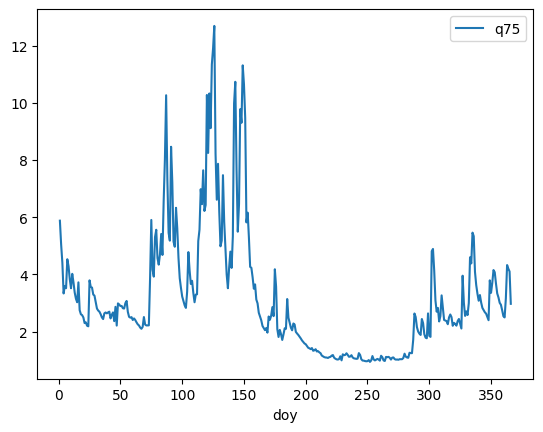

In [285]:
dat.plot(x='doy', y='q75')

In [250]:
d.streamflow.max()

np.float64(167.50999625585973)

<Axes: >

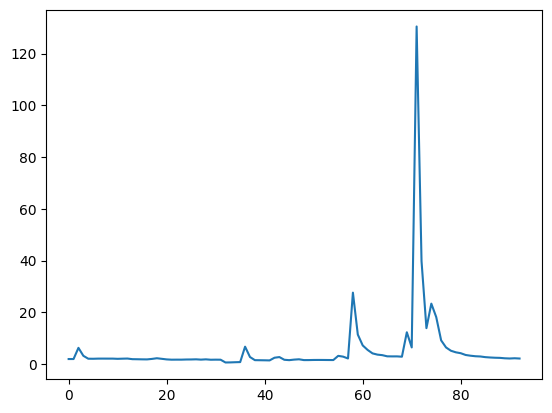

In [252]:
dat.q90.plot()

In [307]:
yearly_maxes = d.groupby(d.time.dt.year).max()

In [309]:
yearly_maxes.streamflow.quantile([0.25, 0.5, 0.75, 0.9])

0.25     60.199999
0.50    126.289997
0.75    215.479995
0.90    325.531993
Name: streamflow, dtype: float64

In [302]:
d

,time,index,feature_id,streamflow
0,1979-02-01 01:00:00,16,8585160,1.34
1,1979-02-01 02:00:00,339,8585160,1.35
2,1979-02-01 03:00:00,662,8585160,1.35
3,1979-02-01 04:00:00,985,8585160,1.35
4,1979-02-01 05:00:00,1308,8585160,1.35
...,...,...,...,...
385699,2023-01-31 20:00:00,124580793,8585160,1.73
385700,2023-01-31 21:00:00,124581116,8585160,1.73
385701,2023-01-31 22:00:00,124581439,8585160,1.73
385702,2023-01-31 23:00:00,124581762,8585160,1.73


/Users/castro/Documents/work/com_res/fim/generate-fim-inputs/.venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


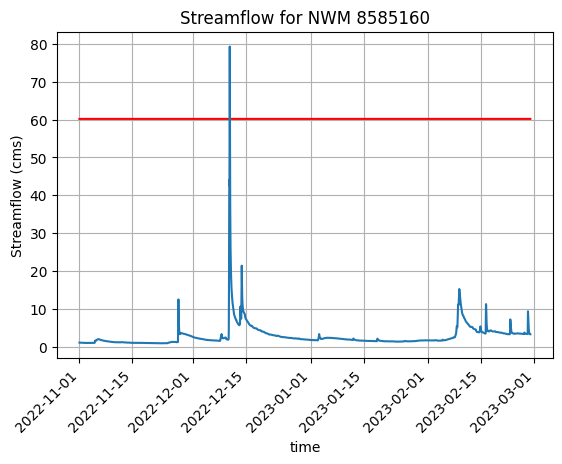

In [311]:

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 

ax.plot(df.index,
        [60.19] * len(df.index),
        label = '.25',
        color='red')

df.streamflow.plot(ax=ax,
                   grid=True,
                   rot=45,
                   title=f'Streamflow for NWM {reach_id}',
                   ylabel='Streamflow (cms)');
